In [148]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Libraries

In [169]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [150]:
import os
label=[]
path=[]
fish_dir='/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name,_,filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png':
            if dir_name.split()[-1]!='GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name,filename))
                
data = pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label

## Data Analysis (EDA)

In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [152]:
data.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Macker...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Macker...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Macker...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Macker...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Macker...,Hourse Mackerel


In [153]:
data.tail()

,path,label
8995,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream/0...,Red Sea Bream
8996,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream/0...,Red Sea Bream
8997,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream/0...,Red Sea Bream
8998,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream/0...,Red Sea Bream
8999,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream/0...,Red Sea Bream


In [154]:
data.describe(include='object')

,path,label
count,9000,9000
unique,9000,9
top,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Macker...,Hourse Mackerel
freq,1,1000


In [155]:
data['label'].unique() # checking unique values

array(['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet',
       'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream',
       'Red Sea Bream'], dtype=object)

In [156]:
f_counts=data['label'].value_counts()  # checking values
print(f_counts)

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64


## Data Visualization in EDA process

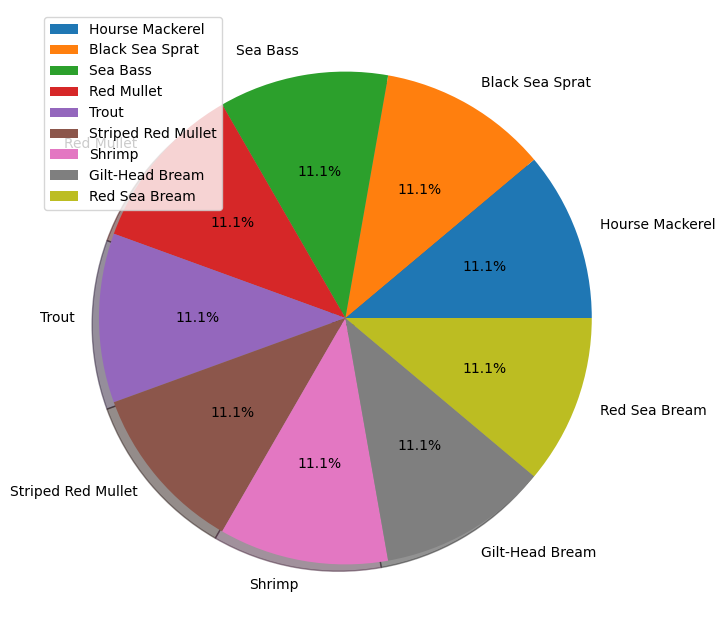

In [157]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.pie(f_counts,labels=f_counts.index,autopct='%1.1f%%',shadow=True)
plt.legend(loc='best')
plt.show()

In [158]:
data.isnull().sum()  # checking null values

path     0
label    0
dtype: int64

In [159]:
data.shape  # checking number of columns and number of datas

(9000, 2)

In [164]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images(df, target_size=(28, 28)):
    images = []
    labels = []
    for index, row in df.iterrows():
        img = load_img(row['path'], target_size=target_size)
        img = img_to_array(img)
        img = img / 255.0  
        images.append(img)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

X, y = load_images(data)

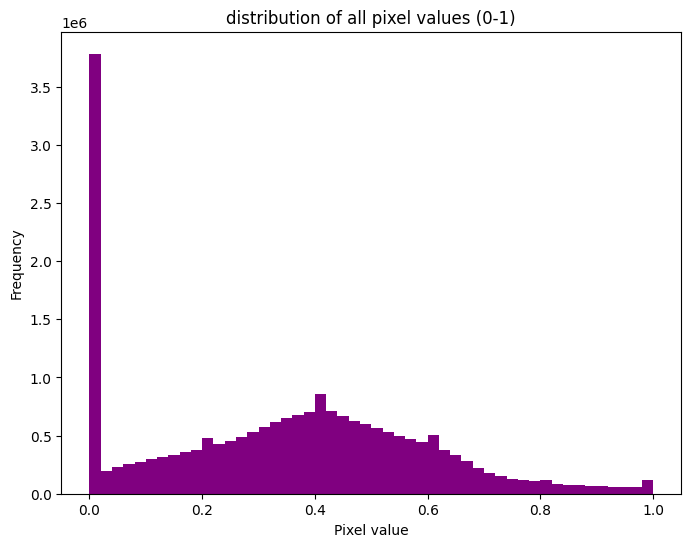

In [165]:
# Distribution of all pixel values (0-1)
plt.figure(figsize=(8, 6))
plt.hist(X.flatten(), bins=50, color="purple")
plt.title("distribution of all pixel values (0-1)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

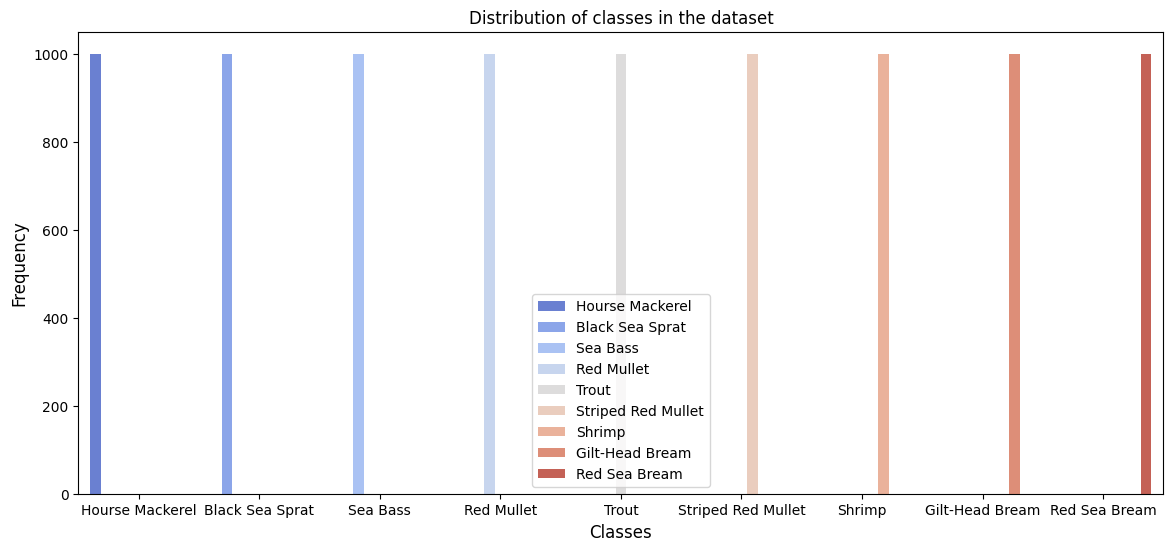

In [166]:
# Distribution of classes in the dataset
plt.figure(figsize= (14,6))
sns.countplot(x = y, palette = "coolwarm", hue = y)
plt.title("Distribution of classes in the dataset")
plt.xlabel("Classes", fontsize = 12)
plt.ylabel("Frequency", fontsize = 12)
plt.show()

## Data Splitting and Augmentation

In [167]:
# Splitting the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

# Data Augmentation for the training set
train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)    
val_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)    
test_generator = ImageDataGenerator(rescale=1./255)

# Loading the images using flow_from_dataframe
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='training'
)

val_images = val_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='validation' 
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=False 
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


## ANN Model

In [170]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 3))) 

# Hidden Layers
model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))

# Output Layer
model.add(tf.keras.layers.Dense(len(train_images.class_indices), activation='softmax'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,113,481 (11.88 MB)

 Trainable params: 3,110,409 (11.87 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [172]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    if epoch >= 20:
        lr *= 0.990 
    return lr

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Compiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training the model
results = model.fit(
    train_images, 
    epochs=100, 
    batch_size=64, 
    validation_data=val_images,
    callbacks=[early_stopping, lr_scheduler_callback]
)

In [ ]:
# Evaluate on the test data
test_loss, test_accuracy = model.evaluate(test_images)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

In [ ]:
# Predictions
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
y_true = test_images.classes

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_images.class_indices.keys(), yticklabels=test_images.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))